In [ ]:
CNN + RNN ( LSTM )  CTC loss로 학습

In [1]:
!nvidia-smi

Wed Feb 23 11:00:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image label은 file명

In [3]:
!wget https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -q captcha_images_v2.zip

--2022-02-23 11:04:03--  https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AakashKumarNain/CaptchaCracker/master/captcha_images_v2.zip [following]
--2022-02-23 11:04:04--  https://raw.githubusercontent.com/AakashKumarNain/CaptchaCracker/master/captcha_images_v2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9075967 (8.7M) [application/zip]
Saving to: ‘captcha_images_v2.zip’

captcha_images_v2.z 100%[===================>]   8.66M  --.-KB/s    in 0.07s   

2022-02-23 11:04:05 (122 MB/s) - ‘captcha_images_v2.z

In [5]:
img_list = glob('captcha_images_v2/*.png')
len(img_list)
print(img_list[:10])

['captcha_images_v2/ggd7m.png', 'captcha_images_v2/bgd4m.png', 'captcha_images_v2/yx2d4.png', 'captcha_images_v2/33f7m.png', 'captcha_images_v2/mye68.png', 'captcha_images_v2/xf4p4.png', 'captcha_images_v2/75pfw.png', 'captcha_images_v2/x3deb.png', 'captcha_images_v2/445cc.png', 'captcha_images_v2/58pnp.png']


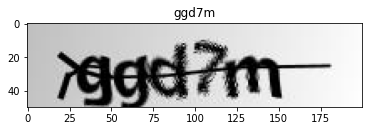

In [6]:
img = cv2.imread(img_list[0])

#os.path.basename : 경로 이름 
label = os.path.splitext(os.path.basename(img_list[0]))[0]

# 예시로 하나 꺼내와서 확인하기
plt.title(label)
plt.imshow(img)

# 전처리 


In [36]:
imgs = []
labels = []
max_length = 0

for img_path in img_list:
  imgs.append(img_path) #이미지 그대로 append

   #split 해서 png 빼고 앞에 label만 가져오기
  label = os.path.splitext(os.path.basename(img_path))[0]
  labels.append(label)

  if len(label) > max_length:
    max_length = len(label)


print(len(imgs), len(labels), max_length)

1040 1040 5


In [8]:
# label unique 추출하기 위해 join 후 set

''.join(labels)

'ggd7mbgd4myx2d433f7mmye68xf4p475pfwx3deb445cc58pnpefg723pe4gm74dmgc83bgd8fb5nnffc4mcmpybeexcf88g8gnd368y5ndme7fp3wyyyg5g268g2mm3nn4cn7b76n7pycnfc64b3pcpe632npg656c34pw5ncen32e8n62n8n5pnddcnee84n23g2w6c8fxycdf77gw53m53mn8p8ngxc482bx4f7gmgdwbfpw76w7e6mmfb3x7bb7bd236nxe6eb5nm6dyf424pmf5w728n8ny3nn5nxnnnny5edd5w5m8gmx7pcd7nnp4e3bnyfyy824n6f4bncyx8bwmeemyf82d22n78y6b3xbem67g3nfd4n82p6mn86ng6w8gf7n6wg4ngny6b65m85nbp3em22e3f83pnnbfx5mmy5nbnc5f4433mnbmx7ng2gwgn2xy785n4x775wbny23dyp7nmwxwpmc35nw48cw264m573mnxc4527xfn6n8wy7d42xpy8e32m3b4we56ncxcfp86pgg3nndg2bbm3p8m25768bbw8xce8dpn7pnnnfx3pgmn2wyc256xpmenf7bn5pm6bg2fnw8w8755n3w4n5n8b5n7286e5546e6pnddcddennmm8d4wmnmy2xn7ebxf6ne5nxxf8mw5p27634y6fgdwddnpfpme86e46ywfy2nde43ymnf2n8b5dn4wye85677g3edg3ppg2yxwecfd3n3cfx3fwfdd764px2xpbyc82y4ec2wdww8yd3m3y53c2bp2d4f35xpxdn65n7mebf8f8gmxyxwnpxb7gxxpfb4ncnmxnw45p8fmwnpecgbxyywxcn86pwcnpg4bfenpw28nn73gcfgp8npe3252575gcd36b46g2gyb6nf8b8n4cpyb4d7c6wb76xngxce2d66nb267mpmy5md3445g5e5865wm5mfffgp7c5bgb48dbpcdymp7

In [10]:
characters = set(''.join(labels))
print(characters)
len(characters)

{'f', 'b', '7', '8', 'e', 'x', 'd', '5', 'w', '6', 'g', 'y', 'p', '4', '2', 'c', 'm', 'n', '3'}


19

# model 학습 위해 label의 문자 encode

In [11]:
# keras의 StringLookup은 스트링 --> 숫자로 
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters) , num_oov_indices=0 , mask_token=None
)

num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary() , num_oov_indices=0 , mask_token=None , invert=True
)

print(labels[0])

# label 하나하나 쪼개서 utf-8로 encoding

encoded = char_to_num(tf.strings.unicode_split(labels[0] , input_encoding='UTF-8'))
print(encoded)


/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


ggd7m
tf.Tensor([10 10  6  2 16], shape=(5,), dtype=int64)


In [12]:
# encode 된 label을 다시 num_to_char로 바꾼 다음에 reduce_join, numpy 말고 string출력 위해 decode
tf.strings.reduce_join(num_to_char(encoded)).numpy().decode('utf-8')

'ggd7m'

# Dataset 

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(imgs, labels, test_size=0.1, random_state=2727)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))

936 936
104 104


# data gernerator 생성

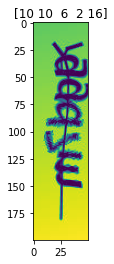

In [17]:
img_width = 200
img_height = 50

def encode_single_sample(img_path, label):
  img = tf.io.read_file(img_path)

  img = tf.io.decode_png(img, channels=1)

  img = tf.image.convert_image_dtype(img, tf.float32)

  img = tf.image.resize(img , [img_height, img_width])
  #세로로 한글자씩 lstm으로 읽기 위해서 tranpose
  img = tf.transpose(img , perm=[1,0,2])
  label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))

  return {'image' : img , 'label':label}

preview = encode_single_sample(imgs[0] , labels[0])

#np.squeeze -- > 축제거
plt.title(str(preview['label'].numpy()))
plt.imshow(preview['image'].numpy().squeeze())

In [22]:
x_train[:10]

['captcha_images_v2/7cgym.png',
 'captcha_images_v2/268g2.png',
 'captcha_images_v2/b5pnn.png',
 'captcha_images_v2/5pm6b.png',
 'captcha_images_v2/mdxpn.png',
 'captcha_images_v2/677g3.png',
 'captcha_images_v2/4exnn.png',
 'captcha_images_v2/x775w.png',
 'captcha_images_v2/xyncc.png',
 'captcha_images_v2/yeyn4.png']

In [24]:
batch_size = 32

# 주어진 데이터소스를 여러 tensor로 자름  *tensor : 다차원
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(    #num_parallel_calls : 여러개의 스레드로 나눠서 속도 높여서 처리 가능 
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    #prefecth --> 학습 데이터를 나눠서 읽어보기 떄문에 리소스의 유휴 상태를 줄일 수 있음
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

print(train_dataset)
print(validation_dataset)

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>
<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>


#model 생성

In [34]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

def build_model():
  input_img = layers.Input(
      shape=(img_width, img_height, 1) , name='image' , dtype='float32' 
  )
  labels = layers.Input(name='label', shape=(None,), dtype='float32')

  x = layers.Conv2D(
      32,
      (3,3),
      activation='relu',
      kernel_initializer='he_normal',
      padding = 'same',
      name='Conv1',
  )(input_img)
  x = layers.MaxPooling2D((2,2) , name='poll1')(x)

  x = layers.Conv2D(
          64,
          (3, 3),
          activation='relu',
          kernel_initializer='he_normal',
          padding='same',
          name='Conv2',
      )(x)
  x = layers.MaxPooling2D((2, 2), name='pool2')(x)

  #maxpooling2로  2번 했기 때문에 2 * 2 
  new_shape = ((img_width // 4), (img_height // 4) * 64)
  x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
  x = layers.Dense(64, activation='relu', name='dense1')(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
  x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

  # Output layer +1을 하는 이유는 인식하지 못했을 경우를 추가하는것 
  x = layers.Dense(
      len(char_to_num.get_vocabulary()) + 1, activation='softmax', name='dense2'
  )(x)

  # Add CTC layer for calculating CTC loss at each step
  output = CTCLayer(name='ctc_loss')(labels, x)

  # Define the model
  model = keras.models.Model(
      inputs=[input_img, labels], outputs=output, name='ocr_model_v1'
  )
  # Optimizer
  opt = keras.optimizers.Adam()
  # Compile the model and return
  model.compile(optimizer=opt)
  return model


# Get the model
model = build_model()
model.summary()




Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 poll1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['poll1[0][0]']       

# model train

In [35]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss' , patience=10 , restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[early_stopping],
)

TypeError: ignored

# test 해보기

In [ ]:
#예측모델 생성
prediction_model = keras.models.Model(
    model.get_layer(name='image').input, model.get_layer(name='dense2').output
)

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text

for batch in validation_dataset.take(1):
    batch_images = batch['image']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    _, axes = plt.subplots(8, 4, figsize=(16, 12))

    for img, text, ax in zip(batch_images, pred_texts, axes.flatten()):
        img = img.numpy().squeeze()
        img = img.T

        ax.imshow(img, cmap='gray')
        ax.set_title(text)
        ax.set_axis_off()